In [5]:
# Block 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from PyMPDATA import Options, Stepper, Solver, ScalarField, VectorField
from PyMPDATA.boundary_conditions import Periodic

In [6]:
# Configure PyMPDATA options for 1D advection
opts = Options(n_iters=2, infinite_gauge=True, nonoscillatory=True)  # 2 iterations for 2nd-order accuracy

# Define domain and simulation parameters
Lx = 1000.0       # domain length in arbitrary units (e.g., 0 to 1000)
Nx = 1000         # number of grid cells
dx = Lx / Nx      # grid spacing
x = np.linspace(0, Lx, Nx, endpoint=False)  # cell-center coordinates
c = 1.0           # advection speed (units of length per time)
dt = 1.0          # time step size (e.g., 1 second)
omega = 2 * np.pi / 400.0  # oscillator frequency (one period = 400 time units):contentReference[oaicite:4]{index=4}

# Total simulation time and steps
T = 1400.0        # total simulated time (e.g., 1400 s)
n_steps = int(T / dt)
print(f"Grid: {Nx} points, dx={dx}. dt={dt}, steps={n_steps}, c={c}, omega={omega:.4f}")


Grid: 1000 points, dx=1.0. dt=1.0, steps=1400, c=1.0, omega=0.0157


In [7]:
# Block 2: Initial Conditions
# Define a raised cosine bump for psi between x=50 and x=150, zero elsewhere
psi0 = np.zeros(Nx)
mask = (x >= 50) & (x <= 150)
# Cosine bump: psi = 0.5 * [1 + cos(pi * (x - center)/width)] within the interval
psi0[mask] = 0.5 * (1 + np.cos(np.pi * (x[mask] - 100) / 50))
psi0_max = psi0.max()
psi0 /= psi0_max   # normalize peak to 1.0 for convenience
phi0 = np.zeros(Nx)

print(f"Initial psi peak = {psi0.max():.2f} at x ~{x[np.argmax(psi0)]}, phi everywhere = {phi0.min():.1f}")


Initial psi peak = 1.00 at x ~100.0, phi everywhere = 0.0


In [8]:
# Block 3: Solver Setup (Stepper, Fields, Advector)
# Create a Stepper for 1D advection with the specified options
stepper = Stepper(options=opts, n_dims=1)

# Initialize ScalarField objects for psi and phi, including halo for boundary conditions
halo = stepper.options.n_halo  # number of halo points required by scheme
bc = (Periodic(), Periodic())  # periodic BC at domain start and end
psi_field = ScalarField(data=psi0, halo=halo, boundary_conditions=bc)
phi_field = ScalarField(data=phi0, halo=halo, boundary_conditions=bc)

# Set up the constant velocity field as a VectorField.
# For 1D, advector data is a tuple with one numpy array (velocity in x-direction).
# We fill it with the constant c at all staggered points (length Nx+1 for periodic domain).
u = np.full(Nx+1, c)
u_field = VectorField(data=(u,), halo=halo, boundary_conditions=bc)

# Create Solver instances for psi and phi using the same stepper and velocity field
solver_psi = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
solver_phi = Solver(stepper=stepper, advectee=phi_field, advector=u_field)


In [9]:
# Block 4: Simulation Loop – Explicit Euler Coupling
# Reset fields to initial state
psi_field.get()[:] = psi0  # note: use .get() to access the data array without halos
phi_field.get()[:] = phi0

# Time integration with explicit Euler coupling
for n in range(n_steps):
    psi_old = psi_field.get().copy()
    phi_old = phi_field.get().copy()
    # Advect psi and phi one step (MPDATA handles the advection)
    solver_psi.advance(1)
    solver_phi.advance(1)
    # After this, psi_field and phi_field contain advected values (psi*, phi*)
    psi_adv = psi_field.get()
    phi_adv = phi_field.get()
    # Explicit Euler coupling update
    psi_field.get()[:] = psi_adv + dt * omega * phi_old    # ψ^{n+1}
    phi_field.get()[:] = phi_adv - dt * omega * psi_old    # φ^{n+1}

# Store results for analysis
psi_explicit = psi_field.get().copy()
phi_explicit = phi_field.get().copy()
print("Explicit coupling simulation finished.")


Explicit coupling simulation finished.


In [10]:
# Block 5: Simulation Loop – Semi-Implicit Trapezoidal Coupling
# Reset fields to initial state
psi_field.get()[:] = psi0
phi_field.get()[:] = phi0

# Time integration with trapezoidal (semi-implicit) coupling via Strang splitting
for n in range(n_steps):
    psi_old = psi_field.get().copy()
    phi_old = phi_field.get().copy()
    # Half-step explicit coupling
    psi_half = psi_old + 0.5 * dt * omega * phi_old
    phi_half = phi_old - 0.5 * dt * omega * psi_old
    psi_field.get()[:] = psi_half
    phi_field.get()[:] = phi_half
    # Advect over full step with MPDATA
    solver_psi.advance(1)
    solver_phi.advance(1)
    # After advection, get intermediate fields (denoted with * or "half" advected)
    psi_star = psi_field.get().copy()
    phi_star = phi_field.get().copy()
    # Second half-step explicit coupling
    psi_field.get()[:] = psi_star + 0.5 * dt * omega * phi_star
    phi_field.get()[:] = phi_star - 0.5 * dt * omega * psi_star

# Store results for analysis
psi_trapez = psi_field.get().copy()
phi_trapez = phi_field.get().copy()
print("Trapezoidal coupling simulation finished.")


Trapezoidal coupling simulation finished.


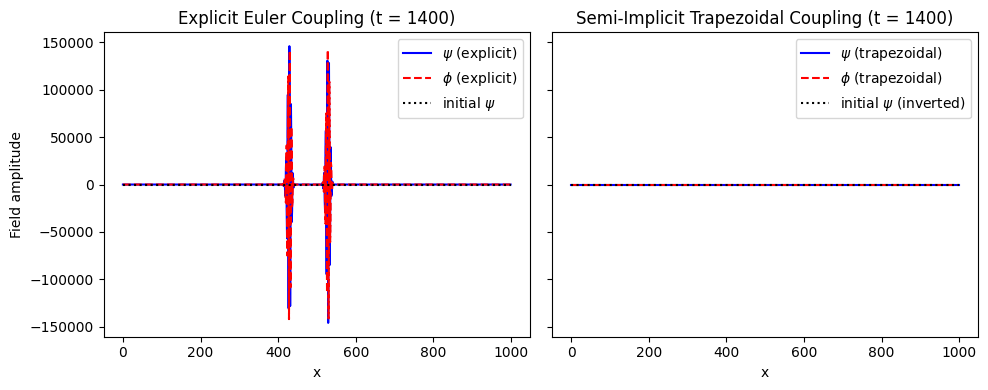

In [11]:
# Block 6: Visualization of Results
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Explicit Euler results
ax = axes[0]
ax.plot(x, psi_explicit, 'b-', label='$\psi$ (explicit)')
ax.plot(x, phi_explicit, 'r--', label='$\phi$ (explicit)')
ax.plot(x, psi0, 'k:', label='initial $\psi$')
ax.set_title("Explicit Euler Coupling (t = 1400)")
ax.set_xlabel("x")
ax.set_ylabel("Field amplitude")
ax.legend(loc="upper right")

# Trapezoidal results
ax = axes[1]
ax.plot(x, psi_trapez, 'b-', label='$\psi$ (trapezoidal)')
ax.plot(x, phi_trapez, 'r--', label='$\phi$ (trapezoidal)')
ax.plot(x, -psi0, 'k:', label='initial $\psi$ (inverted)')
ax.set_title("Semi-Implicit Trapezoidal Coupling (t = 1400)")
ax.set_xlabel("x")
ax.legend(loc="upper right")

plt.tight_layout()
plt.savefig("oscillator_explicit_vs_trapez.png")
plt.show()


In [12]:
def run_explicit_euler_scheme(n_steps, psi0, phi0):
    psi_field.get()[:] = psi0
    phi_field.get()[:] = phi0
    
    for _ in range(n_steps):
        s1 = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
        s2 = Solver(stepper=stepper, advectee=phi_field, advector=u_field)
        
        s1.advance(1)
        s2.advance(1)
        
        po = psi_field.get().copy()
        fo = phi_field.get().copy()
        
        psi_field.get()[:] += dt * omega * fo
        phi_field.get()[:] -= dt * omega * po
        
    psi_ex = psi_field.get().copy()
    phi_ex = phi_field.get().copy()
    
    return psi_ex, phi_ex, psi0


def run_trapezoidal_scheme(n_steps):
    psi_field.get()[:] = psi0
    phi_field.get()[:] = phi0
    
    for _ in range(n_steps):
        pn = psi_field.get().copy()
        fn = phi_field.get().copy()
        
        psi_field.get()[:] = pn + 0.5 * dt * omega * fn
        phi_field.get()[:] = fn - 0.5 * dt * omega * pn
        
        s1 = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
        s2 = Solver(stepper=stepper, advectee=phi_field, advector=u_field)
        
        s1.advance(1)
        s2.advance(1)
        
        ps = psi_field.get().copy()
        fs = phi_field.get().copy()
        
        psi_field.get()[:] = ps + 0.5 * dt * omega * fs
        phi_field.get()[:] = fs - 0.5 * dt * omega * ps
        
    psi_tr = psi_field.get().copy()
    phi_tr = phi_field.get().copy()
    
    return psi_tr, phi_tr, psi0


## Tests

In [24]:
import ipytest
import pytest

ipytest.autoconfig()

In [48]:
%%ipytest -s

def rms(a, b):
    return np.sqrt(np.mean((a - b)**2))


def test_trapezoidal_scheme_psi_is_more_accurate_than_explicit_scheme_psi():
    err_psi_tr = rms(psi_trapez, -psi0)
    err_psi_ex = rms(psi_explicit, -psi0)
    
    assert err_psi_tr < err_psi_ex


def test_trapezoidal_phi_err_is_near_zero():
    err_phi_tr = rms(phi_trapez, np.zeros_like(phi_trapez))
    
    assert err_phi_tr < 1e-4
    

def test_initial_conditions():
    """
    Verifies the initial state of psi0 and phi0.
    - psi0 should have a peak of 1.0 at x=100.0.
    - phi0 should be zero everywhere.
    """
    psi0_peak_val = np.max(psi0)
    
    assert np.allclose(psi0_peak_val, 1.0), f'psi0 peak value is {psi0_peak_val:.4f}, expected ~1.0'

    psi0_peak_idx = np.argmax(psi0)
    psi0_peak_pos = x[psi0_peak_idx]
    expected_peak_pos = 100.0
    
    assert np.allclose(psi0_peak_pos, expected_peak_pos), f"psi0 peak position is {psi0_peak_pos:.4f}, expected {expected_peak_pos:.1f}"
    
    assert np.all(phi0 == 0.0), f'phi0 is not all zeros. Sum of absolute values: {np.sum(np.abs(phi0)):.4e}'


def test_advection_propagation():
    """
    Verifies that the initial psi bump advects at speed 'c'.
    Runs a short simulation (50 steps) using the explicit scheme.
    Checks the new peak location of psi.
    """
    short_n_steps = 50
    initial_peak_pos_psi0 = x[np.argmax(psi0)]

    psi_ex_short, _, = run_explicit_euler_scheme(short_n_steps, psi0, phi0)

    expected_shift = c * dt * short_n_steps
    expected_peak_pos_short = (initial_peak_pos_psi0 + expected_shift) % Lx

    current_peak_pos_short = x[np.argmax(psi_ex_short)]
    
    err_msg = f'Psi peak (explicit, {short_n_steps} steps) at x={current_peak_pos_short:.2f}, expected ~{expected_peak_pos_short:.2f} (initial at {initial_peak_pos_psi0:.2f}, shift {expected_shift:.2f}).'
    
    assert np.allclose(current_peak_pos_short, expected_peak_pos_short, atol=5.0 * dx), err_msg

...
3 passed in 0.02s
